In [310]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy
from matplotlib.lines import Line2D

# ======
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.rnn_cryptic_equals import convert_seq2inputs, calculate_output, onehot2seq 

In [94]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.001)
                
def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [inp, '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_self(op, inputs):
    seq = []
    for inp in inputs:
        trial = generate_trials(op, inp, inp)
        seq += trial
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse_primitives(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    n = int(len(inputs1)/2)
    for i in range(n):
        trial = [inputs1[i], (op, inputs2[i+n]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict))
    return inps


## running function
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 



In [95]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
input_vals.sort()
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms)
rp = generate_other_reverse_primitives('+', all_syms)
print(primitives)
print(rp)

{'A': 4, 'B': 9, 'C': 10, 'D': 15}
[['A', '=', 4], ['B', '=', 9], ['C', '=', 10], ['D', '=', 15]]
[['A', ('+', 'C'), '=', 14], ['B', ('+', 'D'), '=', 24]]


In [96]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1200
num_sims = 104

In [215]:
## calculate distance matrices for all models and steps 

def calculate_RDMs(res):
    ## find indices of 100% acc rnns
    acc_df = res['acc_df']
    all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)].index
    print('no. 100% trained RNNs: ', len(all_acc_mods))

    mod_list = all_acc_mods # choose only rnns trained to 100%
    # mod_list = np.arange(num_sims)

    # initialise empty lists/arrays
    rdms = [[] for _ in range(4)]
    rdms_p = [[] for _ in range(4)]

    # extracts results from dictionary
    mods = res['mods']
    mods_p = res['mods_p']
    cue_dicts = res['cue_dicts']
    testseq = generate_trials(ops, all_syms, all_syms)
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
            
        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)
            
    return {'rdms': rdms, 'rdms_p': rdms_p, 'ft_cue_dicts': ft_cue_dicts}

rank_dict = {'A': -1.5, 'B': -0.5, 'C': 0.5, 'D': 1.5}

def regress_RDM_abs(time_step, rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        truth_outs = [t[-1] for t in curr_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        x = rdm[time_step][i].reshape(-1,1)
        y = truth_RDM.reshape(16*16)
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        rs.append(r_sq)
    return rs

def regress_RDM_abs_init(time_step, rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        init_tests = [[t[0]]+['='] for t in curr_tests ]
        truth_outs = [calculate_output(t, cuedict) for t in init_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        x = rdm[time_step][i].reshape(-1,1)
        y = truth_RDM.reshape(16*16)
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        rs.append(r_sq)
    return rs

# Read data

In [158]:
# read data

save_dir = '../results/representation_analysis/'

with open(save_dir+'other/res_other', 'rb') as f:
    res1 = pickle.load(f)
    
with open(save_dir+'full/res_full', 'rb') as f:
    res2 = pickle.load(f)
    
with open(save_dir+'balanced_other/res_balanced', 'rb') as f:
    res3 = pickle.load(f)

# Regression

In [160]:
from sklearn.linear_model import LinearRegression

In [321]:
def plot_RDM_regression(dms, dms_p, ft_cue_dicts, ranked = False, title = ''):
    step_rs = []
    step_rs_p = []
    step_num = []
    for s in range(4): 
        if s <= 1:
            rs = regress_RDM_abs_init(s, dms, ft_cue_dicts, ranked)
            rs_p = regress_RDM_abs_init(s, dms_p, ft_cue_dicts, ranked)
        else:
            rs = regress_RDM_abs(s, dms, ft_cue_dicts, ranked)
            rs_p = regress_RDM_abs(s, dms_p, ft_cue_dicts, ranked)
        step_rs.append(rs)
        step_rs_p.append(rs_p)
        step_num.append([s+1]*len(rs))


    r_sq = [item for sublist in step_rs for item in sublist]
    r_sq_p = [item for sublist in step_rs_p for item in sublist]
    steps = [item for sublist in step_num for item in sublist]

    all_r_sq = r_sq + r_sq_p
    all_steps = steps + steps
    training = ['no primitives']*len(r_sq) + ['with primitives']*len(r_sq_p)

    r_sq_scores = pd.DataFrame({'R_squared': all_r_sq, 'Step': all_steps, 'Training': training})
    x_data = np.append((np.array(steps) - 0.2), (np.array(steps) + 0.2))
    x_jittered = np.array(x_data) + np.random.normal(0,0.05,len(x_data))
    x_jittered = x_jittered - 1
    colors = ['blue']*len(r_sq) + ['orange']*len(r_sq_p)    

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='without primitives'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='with primitives')] 

    fig, ax = plt.subplots(figsize= (8,5))
    violins = sns.violinplot(data=r_sq_scores, x="Step", y="R_squared", hue="Training",\
                             palette = ['white', 'white'])

    for x, y, color in zip(x_jittered, r_sq_scores["R_squared"], colors):
        ax.scatter(x, y, s = 20, color=color, alpha=0.2)

    plt.legend(handles=legend_elements)
    plt.title('Regression between model RDM and ground truth' + title)


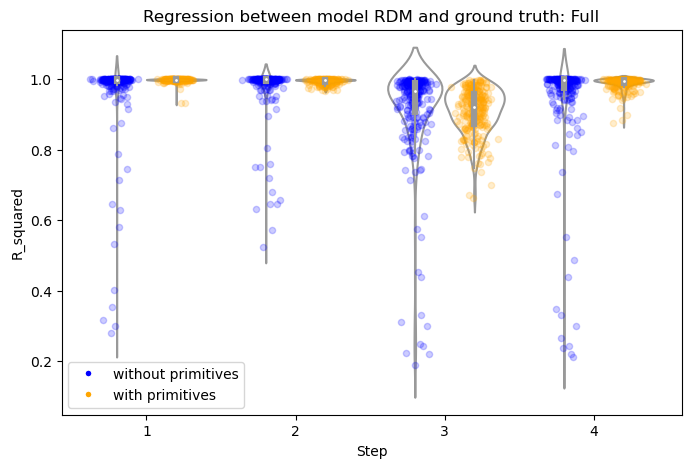

In [318]:
# Full
full_rdmats = calculate_RDMs(res2)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

plot_RDM_regression(dms, dms_p, ft_cue_dicts, title = ': Full')

no. 100% trained RNNs:  526


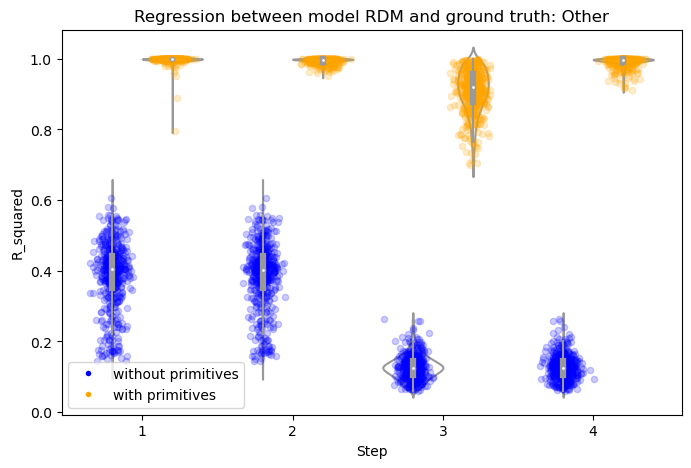

In [319]:
# other
other_rdmats = calculate_RDMs(res1)
dms = other_rdmats['rdms']
dms_p = other_rdmats['rdms_p']
ft_cue_dicts =  other_rdmats['ft_cue_dicts']

plot_RDM_regression(dms, dms_p, ft_cue_dicts, title = ': Other')

no. 100% trained RNNs:  280


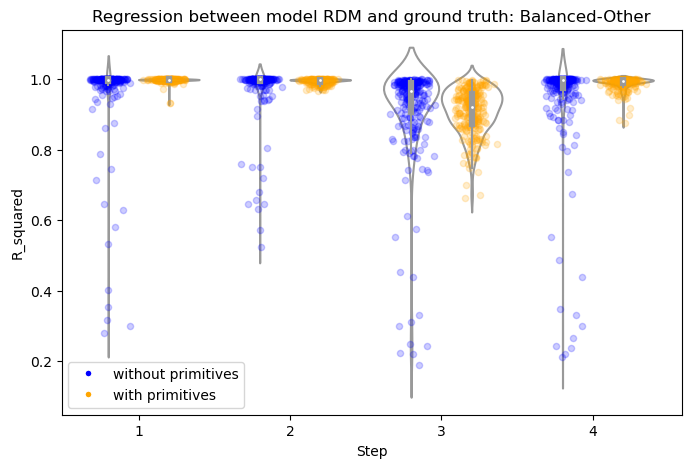

In [320]:
# balanced
balanced_rdmats = calculate_RDMs(res3)
dms = balanced_rdmats['rdms']
dms_p = balanced_rdmats['rdms_p']
ft_cue_dicts =  balanced_rdmats['ft_cue_dicts']

plot_RDM_regression(dms, dms_p, ft_cue_dicts, title = ': Balanced-Other')

In [ ]:
## ranked RDM

no. 100% trained RNNs:  247


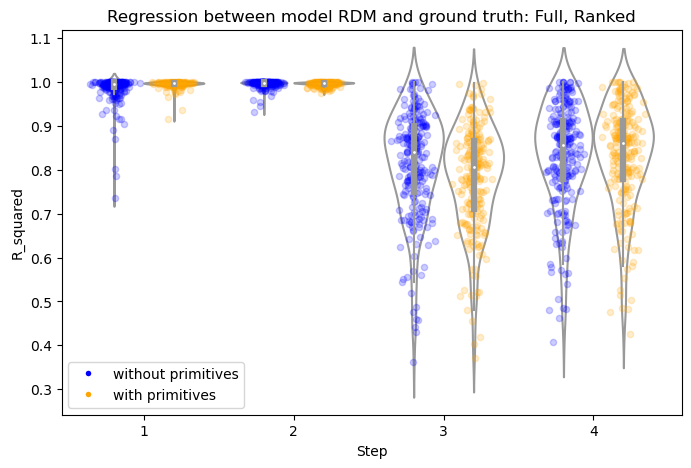

In [322]:
# Full
full_rdmats = calculate_RDMs(res2)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

plot_RDM_regression(dms, dms_p, ft_cue_dicts, ranked=True, title = ': Full, Ranked')

no. 100% trained RNNs:  526


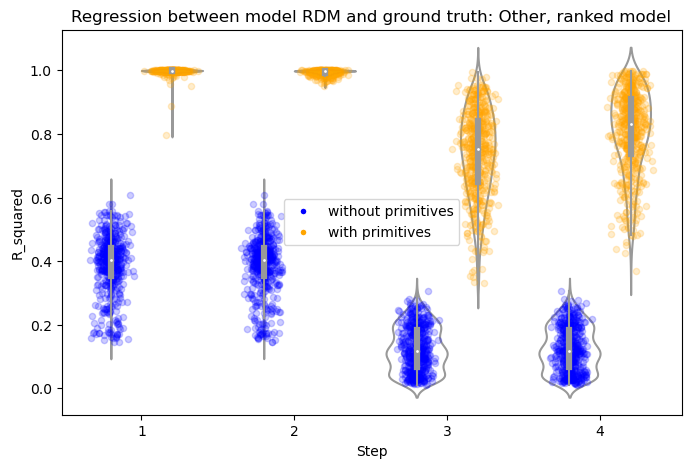

In [323]:
# other
other_rdmats = calculate_RDMs(res1)
dms = other_rdmats['rdms']
dms_p = other_rdmats['rdms_p']
ft_cue_dicts =  other_rdmats['ft_cue_dicts']

plot_RDM_regression(dms, dms_p, ft_cue_dicts, ranked=True, title = ': Other, ranked model')

no. 100% trained RNNs:  280


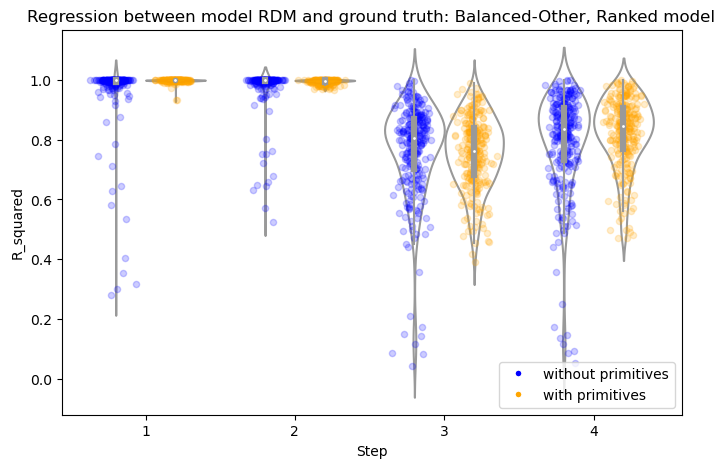

In [324]:
# balanced
balanced_rdmats = calculate_RDMs(res3)
dms = balanced_rdmats['rdms']
dms_p = balanced_rdmats['rdms_p']
ft_cue_dicts =  balanced_rdmats['ft_cue_dicts']

plot_RDM_regression(dms, dms_p, ft_cue_dicts, ranked=True, title = ': Balanced-Other, Ranked model')

no. 100% trained RNNs:  526
step:  1
WilcoxonResult(statistic=0.0, pvalue=7.189158318658634e-88) 

step:  2
WilcoxonResult(statistic=0.0, pvalue=7.189158318658634e-88) 

step:  3
WilcoxonResult(statistic=0.0, pvalue=7.189158318658634e-88) 

step:  4
WilcoxonResult(statistic=0.0, pvalue=7.189158318658634e-88) 



Text(0.5, 0.98, 'Other')

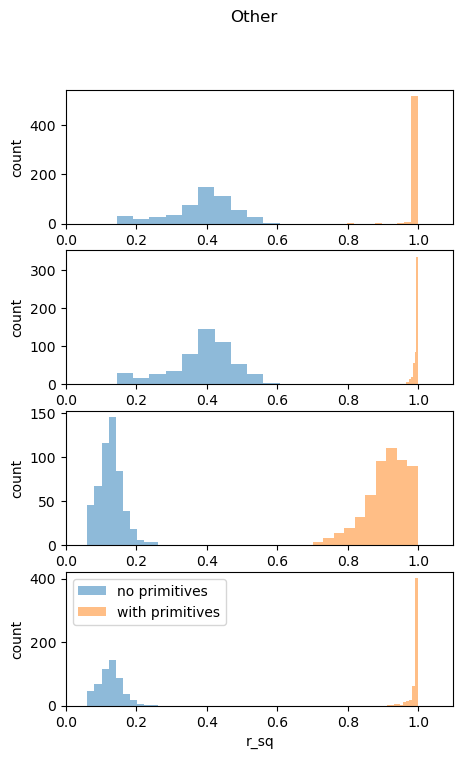

In [212]:
# other

full_rdmats = calculate_RDMs(res1)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']


plt.rcParams["figure.figsize"] = (5,8)
fig, ax = plt.subplots(4,1)
for s in range(4): 
    if s <= 1:
        rs = regress_RDM_abs_init(s, dms, ft_cue_dicts)
        rs_p = regress_RDM_abs_init(s, dms_p, ft_cue_dicts)
    else:
        rs = regress_RDM_abs(s, dms, ft_cue_dicts)
        rs_p = regress_RDM_abs(s, dms_p, ft_cue_dicts)
    print('step: ', s+1)
    print(scipy.stats.wilcoxon(rs, rs_p, zero_method = 'wilcox'), '\n')
    ax[s].hist(rs, alpha=0.5, label = 'no primitives')
    ax[s].hist(rs_p, alpha=0.5, label = 'with primitives')
    ax[s].set_xlim(0,1.1)
    ax[s].set_ylabel('count')
ax[-1].set_xlabel('r_sq')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.suptitle('Other')

no. 100% trained RNNs:  526
step:  1
WilcoxonResult(statistic=0.0, pvalue=7.189158318658634e-88) 

step:  2
WilcoxonResult(statistic=0.0, pvalue=7.189158318658634e-88) 

step:  3
WilcoxonResult(statistic=0.0, pvalue=7.189158318658634e-88) 

step:  4
WilcoxonResult(statistic=0.0, pvalue=7.189158318658634e-88) 



Text(0.5, 0.98, 'Other')

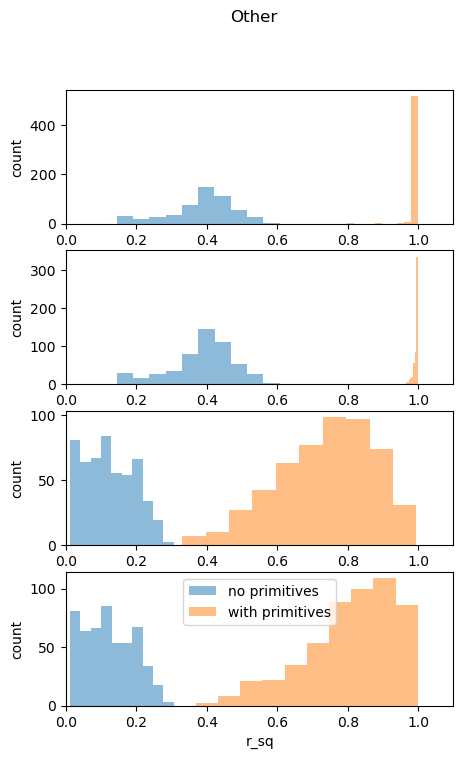

In [216]:
# other - ranked

full_rdmats = calculate_RDMs(res1)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']


plt.rcParams["figure.figsize"] = (5,8)
fig, ax = plt.subplots(4,1)
for s in range(4): 
    if s <= 1:
        rs = regress_RDM_abs_init(s, dms, ft_cue_dicts, ranked = True)
        rs_p = regress_RDM_abs_init(s, dms_p, ft_cue_dicts, ranked = True)
    else:
        rs = regress_RDM_abs(s, dms, ft_cue_dicts, ranked = True)
        rs_p = regress_RDM_abs(s, dms_p, ft_cue_dicts, ranked = True)
    print('step: ', s+1)
    print(scipy.stats.wilcoxon(rs, rs_p, zero_method = 'wilcox'), '\n')
    ax[s].hist(rs, alpha=0.5, label = 'no primitives')
    ax[s].hist(rs_p, alpha=0.5, label = 'with primitives')
    ax[s].set_xlim(0,1.1)
    ax[s].set_ylabel('count')
ax[-1].set_xlabel('r_sq')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.suptitle('Other')

no. 100% trained RNNs:  247
step:  1
WilcoxonResult(statistic=8504.0, pvalue=1.3726928150193064e-09) 

step:  2
WilcoxonResult(statistic=9488.0, pvalue=2.180939309561737e-07) 

step:  3
WilcoxonResult(statistic=3362.0, pvalue=2.0853117440043788e-26) 

step:  4
WilcoxonResult(statistic=7573.0, pvalue=5.7008601413862356e-12) 



Text(0.5, 0.98, 'full')

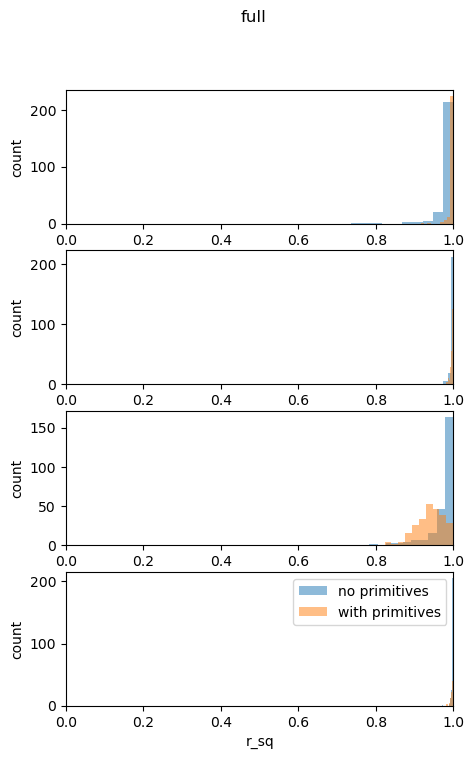

In [180]:
# full

full_rdmats = calculate_RDMs(res2)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']


plt.rcParams["figure.figsize"] = (5,8)
fig, ax = plt.subplots(4,1)
for s in range(4): 
    if s <= 1:
        rs = regress_RDM_abs_init(s, dms, ft_cue_dicts)
        rs_p = regress_RDM_abs_init(s, dms_p, ft_cue_dicts)
    else:
        rs = regress_RDM_abs(s, dms, ft_cue_dicts)
        rs_p = regress_RDM_abs(s, dms_p, ft_cue_dicts)
    print('step: ', s+1)
    print(scipy.stats.wilcoxon(rs, rs_p, zero_method = 'wilcox'), '\n')
    ax[s].hist(rs, alpha=0.5, label = 'no primitives')
    ax[s].hist(rs_p, alpha=0.5, label = 'with primitives')
    ax[s].set_xlim(0,1.1)
    ax[s].set_ylabel('count')
ax[-1].set_xlabel('r_sq')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.suptitle('full')

no. 100% trained RNNs:  247
step:  1
WilcoxonResult(statistic=8504.0, pvalue=1.3726928150193064e-09) 

step:  2
WilcoxonResult(statistic=9488.0, pvalue=2.180939309561737e-07) 

step:  3
WilcoxonResult(statistic=4593.0, pvalue=1.454074443758257e-21) 

step:  4
WilcoxonResult(statistic=14187.0, pvalue=0.3160261271152396) 



Text(0.5, 0.98, 'full')

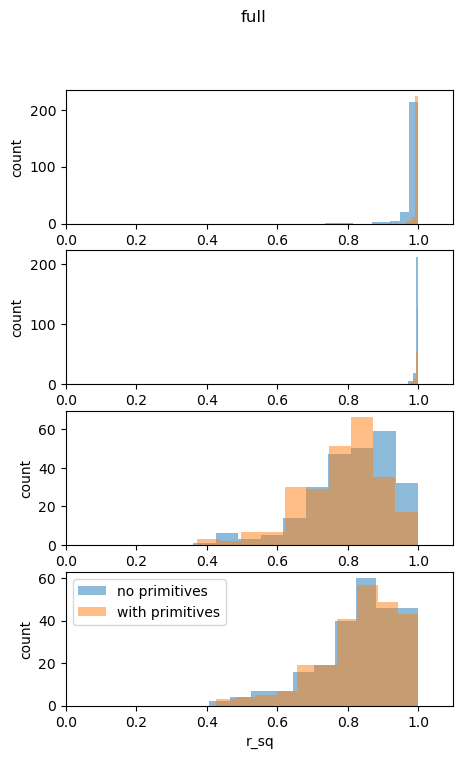

In [217]:
# full - ranked

full_rdmats = calculate_RDMs(res2)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']


plt.rcParams["figure.figsize"] = (5,8)
fig, ax = plt.subplots(4,1)
for s in range(4): 
    if s <= 1:
        rs = regress_RDM_abs_init(s, dms, ft_cue_dicts, ranked = True)
        rs_p = regress_RDM_abs_init(s, dms_p, ft_cue_dicts, ranked = True)
    else:
        rs = regress_RDM_abs(s, dms, ft_cue_dicts, ranked = True)
        rs_p = regress_RDM_abs(s, dms_p, ft_cue_dicts, ranked = True)
    print('step: ', s+1)
    print(scipy.stats.wilcoxon(rs, rs_p, zero_method = 'wilcox'), '\n')
    ax[s].hist(rs, alpha=0.5, label = 'no primitives')
    ax[s].hist(rs_p, alpha=0.5, label = 'with primitives')
    ax[s].set_xlim(0,1.1)
    ax[s].set_ylabel('count')
ax[-1].set_xlabel('r_sq')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.suptitle('full')

no. 100% trained RNNs:  280
step:  1
WilcoxonResult(statistic=14977.0, pvalue=0.0005391139535659472) 

step:  2
WilcoxonResult(statistic=13638.0, pvalue=8.672077120634471e-06) 

step:  3
WilcoxonResult(statistic=10567.0, pvalue=1.914747980030273e-11) 

step:  4
WilcoxonResult(statistic=16172.0, pvalue=0.009898381158759767) 



Text(0.5, 0.98, 'balanced')

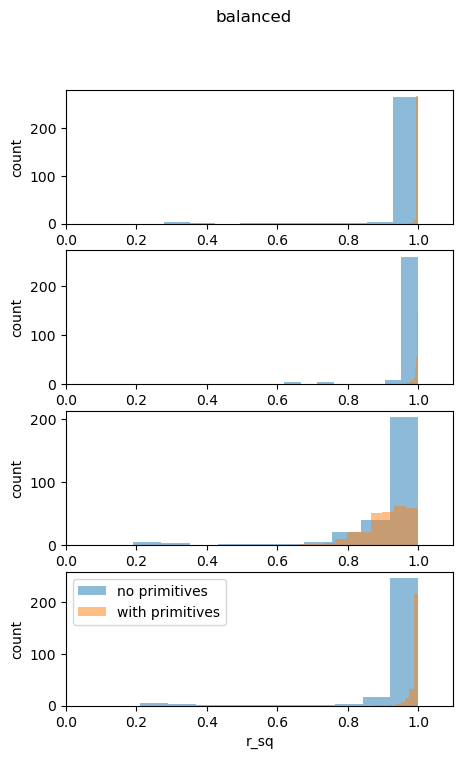

In [206]:
# balanced

full_rdmats = calculate_RDMs(res3)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']


plt.rcParams["figure.figsize"] = (5,8)
fig, ax = plt.subplots(4,1)
for s in range(4): 
    if s <= 1:
        rs = regress_RDM_abs_init(s, dms, ft_cue_dicts)
        rs_p = regress_RDM_abs_init(s, dms_p, ft_cue_dicts)
    else:
        rs = regress_RDM_abs(s, dms, ft_cue_dicts)
        rs_p = regress_RDM_abs(s, dms_p, ft_cue_dicts)
    print('step: ', s+1)
    print(scipy.stats.wilcoxon(rs, rs_p, zero_method = 'wilcox'), '\n')
    ax[s].hist(rs, alpha=0.5, label = 'no primitives')
    ax[s].hist(rs_p, alpha=0.5, label = 'with primitives')
    ax[s].set_xlim(0,1.1)
    ax[s].set_ylabel('count')
ax[-1].set_xlabel('r_sq')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.suptitle('balanced')

no. 100% trained RNNs:  280
step:  1
WilcoxonResult(statistic=14977.0, pvalue=0.0005391139535659472) 

step:  2
WilcoxonResult(statistic=13638.0, pvalue=8.672077120634471e-06) 

step:  3
WilcoxonResult(statistic=11264.0, pvalue=5.703071380403755e-10) 

step:  4
WilcoxonResult(statistic=17236.0, pvalue=0.0726878580182463) 



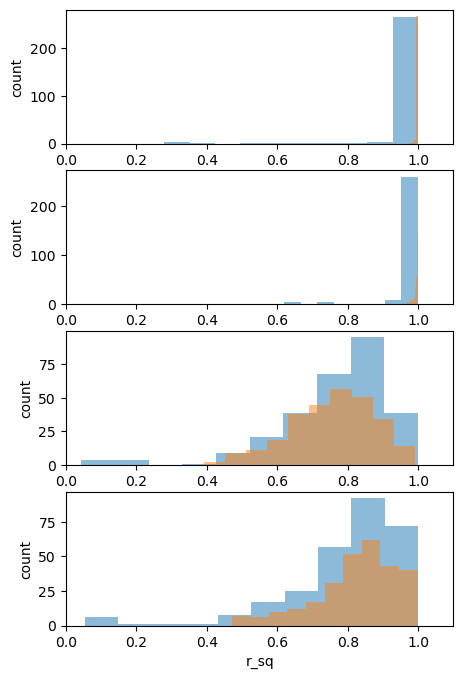

In [218]:
# balanced

full_rdmats = calculate_RDMs(res3)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']


plt.rcParams["figure.figsize"] = (5,8)
fig, ax = plt.subplots(4,1)
for s in range(4): 
    if s <= 1:
        rs = regress_RDM_abs_init(s, dms, ft_cue_dicts, ranked=True)
        rs_p = regress_RDM_abs_init(s, dms_p, ft_cue_dicts, ranked=True)
    else:
        rs = regress_RDM_abs(s, dms, ft_cue_dicts, ranked=True)
        rs_p = regress_RDM_abs(s, dms_p, ft_cue_dicts, ranked=True)
    print('step: ', s+1)
    print(scipy.stats.wilcoxon(rs, rs_p, zero_method = 'wilcox'), '\n')
    ax[s].hist(rs, alpha=0.5, label = 'no primitives')
    ax[s].hist(rs_p, alpha=0.5, label = 'with primitives')
    ax[s].set_xlim(0,1.1)
    ax[s].set_ylabel('count')
ax[-1].set_xlabel('r_sq')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
